In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


jnkcsdncn

In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FL",
    name= "FedAvg_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "loss": nn.BCELoss(),
    "batch_size": 64,
    "decay":1e-5,
    'dropout': 0.1, 
    "learning_rate_FL": 0.001,
    "batch_size_FL": 64,
    "decay_FL":1e-5,
    'num_rounds_FL': 30, 
    'epochs_FL': 100,
    'dropout_FL': 0.01
    
    }
)

configuration  = dict(wandb.config)


def data_loading_AZURE(data_path, label_path, batch_size, train_ratio=0.8, val_ratio=0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    print((labels==1).sum())
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # self.conv0 = nn.Conv1d(in_channels=24, out_channels=4, kernel_size=3)
        # self.bn0 = nn.BatchNorm1d(4)
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv0(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, decay, dropout):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            # train_loss = float(l)
            # losses.append(train_loss) # Stores the loss for this batch
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
            # wandb.log({"train_loss": losses,
            #            "train_acc": train_accs,
            #            "Epoch": epoch + 1})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    print(train_accs)
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Testing accuracy')
    plt.title('accuracies')

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])
AZURE = data_loading_AZURE(data_path='AZURE_data_50.pt', label_path='AZURE_label_50.pt', batch_size= configuration['batch_size'])
# train_loaders = [NASA[0], AZURE[0]]
# val_loaders = [NASA[1], AZURE[1]]
# test_loaders = [NASA[2], AZURE[2]]

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)
tensor(76)
torch.Size([836, 4, 50])
(1520, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 47.536495208740234.

Epoch 2/100
Epoch 2: Training accuracy: 52.28102111816406.

Epoch 3/100
Epoch 3: Training accuracy: 58.12043762207031.

Epoch 4/100
Epoch 4: Training accuracy: 64.32481384277344.

Epoch 5/100
Epoch 5: Training accuracy: 63.868614196777344.

Epoch 6/100
Epoch 6: Training accuracy: 63.68613052368164.

Epoch 7/100
Epoch 7: Training accuracy: 65.51094818115234.

Epoch 8/100
Epoch 8: Training accuracy: 66.1496353149414.

Epoch 9/100
Epoch 9: Training accuracy: 65.96715545654297.

Epoch 10/100
Epoch 10: Training accuracy: 68.52189636230469.

Epoch 11/100
Epoch 11: Training accuracy: 69.61679077148438.

Epoch 12/100
Epoch 12: Training accuracy: 70.43795776367188.

Epoch 13/100
Epoch 13: Training accuracy: 71.71533203125.

Epoch 14/100
Epoch 14: Training accuracy: 71.89781188964844.

Epoch 15/100
Epoch 15: Training accuracy: 72.1715316772461.

Epoch 16/100
Epoch 16: Training accuracy: 73.90511322021484.

Epoch 17/100
Epoch 17: Train

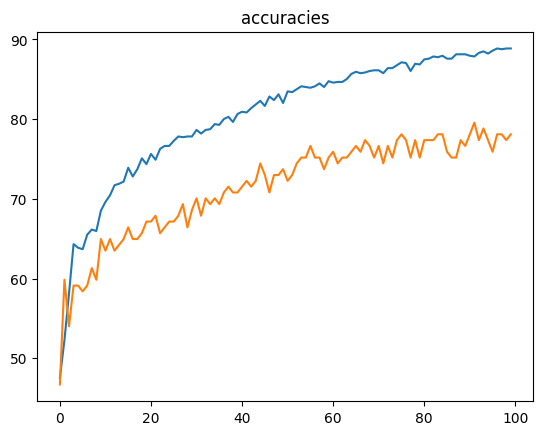

In [6]:
# trainloader = train_loaders[0]
# valloader = val_loaders[0]
# testloader = test_loaders[0]
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = SimpleCNN().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'], configuration['decay'], configuration['dropout'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

testloader = AZURE[2]
trainloader = AZURE[0]
valloader = AZURE[1]
testloader = AZURE[2]
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration2, configuration2['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = SimpleCNN().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

# Federated Learning

importing azure dataset

In [7]:
azure1 = data_loading_AZURE('AZURE_data_1.pt', 'AZURE_label_1.pt', batch_size=configuration['batch_size_FL'])
azure2 = data_loading_AZURE('AZURE_data_2.pt', 'AZURE_label_2.pt', batch_size=configuration['batch_size_FL'])
azure3 = data_loading_AZURE('AZURE_data_3.pt', 'AZURE_label_3.pt', batch_size=configuration['batch_size_FL'])
azure4 = data_loading_AZURE('AZURE_data_4.pt', 'AZURE_label_4.pt', batch_size=configuration['batch_size_FL'])
train_loaders = [azure1[0], azure2[0], azure3[0], azure4[0]]
val_loaders = [azure1[1], azure2[1], azure3[1], azure4[1]]
test_loaders = [azure1[2], azure2[2], azure3[2], azure4[2]]


tensor(167)
torch.Size([1002, 4, 50])
(1670, 4, 50)
tensor(156)
torch.Size([936, 4, 50])
(1560, 4, 50)
tensor(207)
torch.Size([1242, 4, 50])
(2070, 4, 50)
tensor(169)
torch.Size([1014, 4, 50])
(1690, 4, 50)


In [8]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if 'bn' not in name]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'], configuration['decay_FL'], configuration['dropout'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = SimpleCNN().to(device)
    trainloader = train_loaders[int(cid)]
    valloader = val_loaders[int(cid)]
    return FlowerClient(net, trainloader, valloader, configuration).to_client()


In [9]:

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    net = SimpleCNN().to(device)
    testloader = test_loaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'loss': loss,
               "accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}


params = get_parameters(SimpleCNN())
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.7,
    fraction_evaluate=0.5,
    min_fit_clients=1,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params) # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=1,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
2024-08-08 19:26:20,177	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'object_store_memory': 59206678118.0, 'CPU': 32.0, 'memory': 128148915610.0, 'node:192.168.1.146': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      initial parameters (loss, other metrics): 0.23090070486068726, {'accuracy': tensor(52.6946, device='cuda:0')}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sam

Server-side evaluation loss 0.23090070486068726 / accuracy 52.694610595703125
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 1/100
(ClientAppActor pid=1058611) Epoch 1: Training accuracy: 50.449100494384766.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 2/100
(ClientAppActor pid=1058611) Epoch 2: Training accuracy: 49.925148010253906.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 3/100
(ClientAppActor pid=1058611) Epoch 3: Training accuracy: 49.550899505615234.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 4/100
(ClientAppActor pid=1058611) Epoch 4: Training accuracy: 61.077842712402344.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 5/100
(ClientAppActor pid=1058611) Epoch 5: Training accuracy: 74.10179901123047.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 6/100
(ClientAppActor pid=1058611) Epoch 6: Training accuracy: 74.77545166015625.
(ClientAppActor pid=1058611) 
(Clien

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (1, 0.2556047836939494, {'accuracy': tensor(47.3054, device='cuda:0')}, 4.249868749000598)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 85.7035903930664.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 86.15269470214844.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 86.07784271240234.
Server-side evaluation loss 0.2556047836939494 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) [tensor(50.4491, device='cuda:0'), tensor(49.9251, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(61.0778, device='cuda:0'), tensor(74.1018, device='cuda:0'), tensor(74.7755, device='cuda:0'), tensor(75.8234, device='cuda:0'), tensor(75.9731, device='cuda:0'), tensor(78.1437, device='cuda:0'), tensor(78.1437, device='cuda:0'), tensor(77.2455, device='cuda:0'), tensor(75.8982, device='cuda:0'), tensor(76.7964, device='cuda:0'), tensor(77.2455, device='cuda:0'), tensor(77.2455, device='cuda:0'), tensor(

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (2, 0.26405902703603107, {'accuracy': tensor(47.3054, device='cuda:0')}, 7.1533314469852485)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 92: Training accuracy: 86.45209503173828.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 93/100
(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 86.82634735107422.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 86.37724304199219.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 86.45209503173828.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 85.7784423828125.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 86.67664337158203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 86.52694702148438.
(ClientAppActor pid=1058611) 


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 86.67664337158203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 86.9760513305664.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(66.4671, device='cuda:0'), tensor(86.0030, device='cuda:0'), tensor(86.2275, device='cuda:0'), tensor(86.0778, device='cuda:0'), tensor(86.3024, device='cuda:0'), tensor(85.8533, device='cuda:0'), tensor(86.0030, device='cuda:0'), tensor(82.6347, device='cuda:0'), tensor(86.1527, device='cuda:0'), tensor(86.0778, device='cuda:0'), tensor(86.0778, device='cuda:0'), tensor(86.0778, device='cuda:0'), tensor(86.2275, device='cuda:0'), tensor(86.3772, device='cuda:0'), tensor(85.8533, device='cuda:0'), tensor(84.7305, device='cuda:0'), tensor(84.4311, device='cuda:0'), tensor(85.1796, device='cuda:

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (3, 0.270076851050059, {'accuracy': tensor(47.3054, device='cuda:0')}, 10.038346339017153)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 86.82634735107422.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.5748519897461.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 86.22754669189453.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 87.20059967041016.
Server-side evaluation loss 0.270076851050059 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(63.8473, device='cuda:0'), tensor(86.8263, device='cuda:0'), tensor(83.6826, device='cuda:0'), tensor(86.9761, device='cuda:0'), tensor(86.2275, device='cuda:0'), tensor(87.2006, device='cuda:0'), tensor(86.9012, device='cuda:

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (4, 0.2745842933654785, {'accuracy': tensor(47.3054, device='cuda:0')}, 12.935710783989634)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.5748519897461.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 86.15269470214844.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.27545166015625.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
Server-side evaluation loss 0.2745842933654785 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.12574768066406.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 86.75149536132812.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), te

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (5, 0.2759109139442444, {'accuracy': tensor(47.3054, device='cuda:0')}, 15.833687054982875)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 87.20059967041016.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 87.64970397949219.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.5748519897461.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.5748519897461.
(ClientAppActor pid=1058611) 
(

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (6, 0.27813462416330975, {'accuracy': tensor(47.3054, device='cuda:0')}, 18.750952008005697)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.64970397949219.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.5.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 88.0239486694336.
Server-side evaluation loss 0.27813462416330975 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(58.3832, device='cuda:0'), tensor(86.5269, device='cuda:0'), tensor(88.0239, device='cuda:0'), tensor(87.6497, device='cuda:0'), tensor(83.9072, device='cuda:0'), tensor(84.1317, device='cuda:0'), tensor(86.1527, device='cuda:0'), tensor(87.5749, device='cuda:0'), tensor(87.2755, device='cuda:0'), tensor(88.0239, device='cuda:0'), tensor(87.2755, device='cuda:0'), tensor(87.5000, dev

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (7, 0.27960362037022907, {'accuracy': tensor(47.3054, device='cuda:0')}, 21.650714780029375)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 88.09880065917969.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
Server-side evaluation loss 0.27960362037022907 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 87.20059967041016.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(59.5808, device='cuda:0'), tensor(86.2275, device='cuda:0'), tensor(85.329

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (8, 0.28171412150065106, {'accuracy': tensor(47.3054, device='cuda:0')}, 24.617507837014273)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 91: Training accuracy: 86.30239868164062.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 92/100
(ClientAppActor pid=1058611) Epoch 92: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 93/100
(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 86.90119934082031.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.5748519897461.
(ClientAppActor pid=1058611) 


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 86.30239868164062.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(59.8802, device='cuda:0'), tensor(87.7245, device='cuda:0'), tensor(87.7994, device='cuda:0'), tensor(87.8743, device='cuda:0'), tensor(84.3563, device='cuda:0'), tensor(87.8743, device='cuda:0'), tensor(87.7994, device='cuda:0'), tensor(86.0778, device='cuda:0'), tensor(87.7994, device='cuda:0'), tensor(86.5269, device='cuda:0'), tensor(86.7515, device='cuda:0'), tensor(86.7515, device='cuda:0'), tensor(87.3503, device='cuda:0'), tensor(87.9491,

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (9, 0.2822253902753194, {'accuracy': tensor(47.3054, device='cuda:0')}, 27.532068526023068)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 86.75149536132812.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 86.45209503173828.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.09880065917969.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
Server-side evaluation loss 0.2822253902753194 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 86.9760513305664.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(57.0359, device='cuda:0'), tensor(87.5000, device='cuda:0'), tensor(85.4042,

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (10, 0.28367873032887775, {'accuracy': tensor(47.3054, device='cuda:0')}, 30.42431462701643)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 88.24850463867188.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.5.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 86.82634735107422.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.35029602050781.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) [tensor(49.5

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (11, 0.2840522527694702, {'accuracy': tensor(47.3054, device='cuda:0')}, 33.34946056402987)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 91: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 92/100
(ClientAppActor pid=1058611) Epoch 92: Training accuracy: 86.90119934082031.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 93/100
(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 87.20059967041016.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 87.94910430908203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 84.73053741455078.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 86.75149536132812.
(ClientAppActor pid=1058611) 


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(57.8593, device='cuda:0'), tensor(84.8802, device='cuda:0'), tensor(88.2485, device='cuda:0'), tensor(87.5749, device='cuda:0'), tensor(87.5000, device='cuda:0'), tensor(81.3623, device='cuda:0'), tensor(87.2755, device='cuda:0'), tensor(87.7245, device='cuda:0'), tensor(87.8743, device='cuda:0'), tensor(87.7994, device='cuda:0'), tensor(87.6497, device='cuda:0'), tensor(88.0988, device='cuda:0'), tensor(87.2006, device='cuda:0'), tensor(88.0988, 

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (12, 0.2849659522374471, {'accuracy': tensor(47.3054, device='cuda:0')}, 36.24913396697957)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.64970397949219.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.64970397949219.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
Server-side evaluation loss 0.2849659522374471 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 84.58084106445312.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(63.3982, device='cuda:0'), tensor(87.7245, device='cuda:0'), tensor(87.4251,

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (13, 0.2858406901359558, {'accuracy': tensor(47.3054, device='cuda:0')}, 39.207006119017024)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 92: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 93/100
(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 85.47904205322266.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 87.05089569091797.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.5.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.4251480102539.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.17365264892578.
(ClientAppActor pid=1058611) 
(ClientAppActo

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (14, 0.2869641383488973, {'accuracy': tensor(47.3054, device='cuda:0')}, 42.129335645004176)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 83.5329360961914.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.27545166015625.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
Server-side evaluation loss 0.2869641383488973 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(60.0299, device='cuda:0'), tensor(87.7245, device='cuda:0'), tensor(84.5808,

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (15, 0.2867186466852824, {'accuracy': tensor(47.3054, device='cuda:0')}, 45.035067994031124)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 88.17365264892578.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 88.47305297851562.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.94910430908203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 85.55389404296875.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.20059967041016.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 88.47305297851562.
(ClientAppActor pid=1058611

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (16, 0.28730835517247516, {'accuracy': tensor(47.3054, device='cuda:0')}, 47.947632113995496)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 91: Training accuracy: 87.5748519897461.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 92/100
(ClientAppActor pid=1058611) Epoch 92: Training accuracy: 86.9760513305664.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 93/100
(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 86.90119934082031.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.20059967041016.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 86.00299072265625.
(ClientAppActor pid=1058611) 
(Cl

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (17, 0.28734423716862995, {'accuracy': tensor(47.3054, device='cuda:0')}, 50.842922331008594)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.27545166015625.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.5748519897461.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.12574768066406.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
Server-side evaluation loss 0.28734423716862995 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 82.63472747802734.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(58.7575, device='cuda:0'), tensor(88.2485, device='cuda:0'), tensor(88.2485

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (18, 0.2871362368265788, {'accuracy': tensor(47.3054, device='cuda:0')}, 53.76567764102947)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 87.94910430908203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 88.24850463867188.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.17365264892578.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 88.24850463867188.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 88.17365264892578.
Server-side evaluation loss

INFO :      aggregate_fit: received 1 results and 0 failures


(ClientAppActor pid=1058611) Epoch 91: Training accuracy: 88.09880065917969.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 92/100
(ClientAppActor pid=1058611) Epoch 92: Training accuracy: 87.94910430908203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 93/100
(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 87.94910430908203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 88.39820098876953.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 88.24850463867188.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 88.39820098876953.
(ClientAppActor pid=1058611) 


INFO :      fit progress: (19, 0.28752849499384564, {'accuracy': tensor(47.3054, device='cuda:0')}, 56.68377867602976)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.24850463867188.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 81.8113784790039.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 86.9760513305664.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(57.3353, device='cuda:0'), tensor(87.6497, device='cuda:0'), tensor(84.4311, device='cuda:0'), tensor(85.5539, device='cuda:0'), tensor(88.0988, device='cuda:0'), tensor(87.8743, device='cuda:0'), tensor(88.0988, device='cuda:0'), tensor(86.9761, device='cuda:0'), tensor(86.7515, device='cuda:0'), tensor(87.0509, device='cuda:0'), tensor(87.5000, device='cuda:0'), tensor(86.9761, device='cuda:0'), tensor(88.1737, device='cuda:0'), tensor(87.2755, d

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (20, 0.28768924872080487, {'accuracy': tensor(47.3054, device='cuda:0')}, 59.61417661001906)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 91: Training accuracy: 88.39820098876953.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 92/100
(ClientAppActor pid=1058611) Epoch 92: Training accuracy: 88.17365264892578.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 93/100
(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 85.02993774414062.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 86.90119934082031.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 81.8113784790039.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.4251480102539.
(ClientAppActor pid=1058611) 
(

INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.39820098876953.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 88.54790496826172.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 88.09880065917969.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(59.7305, device='cuda:0'), tensor(88.1737, device='cuda:0'), tensor(86.1527, device='cuda:0'), tensor(86.4521, device='cuda:0'), tensor(86.1527, device='cuda:0'), tensor(85.6287, device='cuda:0'), tensor(86.3772, device='cuda:0'), tensor(87.7994, device='cuda:0'), tensor(88.1737, device='cuda:0'), tensor(88.0239, device='cuda:0'), tensor(88.1737, device='cuda:0'), tensor(87.3503, device='cuda:0'), tensor(88.2485, device='cuda:0'), tensor(88.4731,

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (21, 0.2881365617116292, {'accuracy': tensor(47.3054, device='cuda:0')}, 62.528597500000615)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 86.75149536132812.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 88.17365264892578.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 84.35628509521484.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
Server-side evaluation loss 0.2881365617116292 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 87.20059967041016.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(63.6976, device='cuda:0'), tensor(85.4790, device='cuda:0'), tensor(88.0988

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (22, 0.28803592920303345, {'accuracy': tensor(47.3054, device='cuda:0')}, 65.44918177899672)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 88.47305297851562.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 84.056884765625.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 86.90119934082031.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.4251480102539.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.35029602050781.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.54790496826172.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) 
(C

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (23, 0.2887675960858663, {'accuracy': tensor(47.3054, device='cuda:0')}, 68.3667977930163)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 88.24850463867188.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 88.32335662841797.
Server-side evaluation loss 0.2887675960858663 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(59.3563, device='cuda:0'), tensor(83.5329, device='cuda:0'), tensor(88.5479, device='cuda:0'), tensor(88.4731, device='cuda:0'), tensor(87.6497, device='cuda:0'), tensor(87.2755, device='cuda:0'), tensor(88.3234, device='cud

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (24, 0.28837724526723224, {'accuracy': tensor(47.3054, device='cuda:0')}, 71.27874313900247)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.87425231933594.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 88.09880065917969.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
Server-side evaluation loss 0.28837724526723224 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 88.09880065917969.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), t

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (25, 0.28854745626449585, {'accuracy': tensor(47.3054, device='cuda:0')}, 74.18575512699317)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 88.24850463867188.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.64970397949219.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 86.67664337158203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.12574768066406.
(ClientAppActor pid=1058611) 

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (26, 0.28920342524846393, {'accuracy': tensor(47.3054, device='cuda:0')}, 77.10508987098001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.64970397949219.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 87.5.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 86.52694702148438.
Server-side evaluation loss 0.28920342524846393 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(58.6078, device='cuda:0'), tensor(88.0239, device='cuda:0'), tensor(88.4731, device='cuda:0'), tensor(88.3982, device='cuda:0'), tensor(88.3234, device='cuda:0'), tensor(88.0239, device='cuda:0'), tensor(87.7994, device='cuda:0'), tenso

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (27, 0.28859198093414307, {'accuracy': tensor(47.3054, device='cuda:0')}, 80.03778630000306)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 88.17365264892578.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 85.7035903930664.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 88.47305297851562.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 88.54790496826172.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.17365264892578.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 88.54790496826172.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 87.05089569091797.
(ClientAppActor pid=1058611)

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (28, 0.2890467842419942, {'accuracy': tensor(47.3054, device='cuda:0')}, 82.95707389398012)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 91: Training accuracy: 88.39820098876953.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 92/100
(ClientAppActor pid=1058611) Epoch 92: Training accuracy: 88.0239486694336.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 93/100
(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 88.39820098876953.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 87.94910430908203.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 87.79940032958984.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.72454833984375.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 88.32335662841797.
(ClientAppActor pid=1058611) 


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (29, 0.289264440536499, {'accuracy': tensor(47.3054, device='cuda:0')}, 85.87989063502755)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 87.5748519897461.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 87.27545166015625.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.09880065917969.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
Server-side evaluation loss 0.289264440536499 / accuracy 47.305389404296875
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 88.39820098876953.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 100/100
(ClientAppActor pid=1058611) Epoch 100: Training accuracy: 88.09880065917969.
(ClientAppActor pid=1058611) [tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(49.5509, device='cuda:0'), tensor(59.2066, device='cuda:0'), tensor(83.0838, device='cuda:0'), tensor(88.7725, 

INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      fit progress: (30, 0.28927109638849896, {'accuracy': tensor(47.3054, device='cuda:0')}, 88.7970805770019)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 rounds in 88.81s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.24103516340255737\n'
INFO :      	 '\tround 2: 0.2676539619763692\n'
INFO :      	 '\tround 3: 0.25428183873494464\n'
INFO :      	 '\tround 4: 0.249231219291687\n'
INFO :      	 '\tround 5: 0.27162136634190875\n'
INFO :      	 '\tround 6: 0.23821167151133218\n'
INFO :      	 '\tround 7: 0.25697098175684613\n'
INFO :      	 '\tround 8: 0.2677625020345052\n'
INFO :      	 '\tround 9: 0.24480541547139487\n'
INFO :      	 '\tround 10: 0.27889035145441693\n'
INFO :      	 '\tround 11: 0.26011961698532104\n'
INFO :      	 '\tround 12: 

(ClientAppActor pid=1058611) Epoch 93: Training accuracy: 87.5.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 94/100
(ClientAppActor pid=1058611) Epoch 94: Training accuracy: 88.62275695800781.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 95/100
(ClientAppActor pid=1058611) Epoch 95: Training accuracy: 88.54790496826172.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 96/100
(ClientAppActor pid=1058611) Epoch 96: Training accuracy: 88.24850463867188.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 97/100
(ClientAppActor pid=1058611) Epoch 97: Training accuracy: 86.82634735107422.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 98/100
(ClientAppActor pid=1058611) Epoch 98: Training accuracy: 88.62275695800781.
(ClientAppActor pid=1058611) 
(ClientAppActor pid=1058611) Epoch 99/100
(ClientAppActor pid=1058611) Epoch 99: Training accuracy: 86.90119934082031.
(ClientAppActor pid=1058611) 
(ClientAppAc

In [11]:
fl_acc

[tensor(52.6946, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, device='cuda:0'),
 tensor(47.3054, dev

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
def weighted_average(metrics) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    # client_resources=client_resources,
)

# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=fl.server.strategy.FedAvg(),
    client_resources=client_resources
)